# All imports #

In [14]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll
from keras_uncertainty.models import DeepEnsembleRegressor, deep_ensemble_regression_nll_loss



In [15]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [16]:
##please select the appropriate folder, willl use os.path.join() for completed script
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')
x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')
x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

# Splitting the dataset with SD #

In [4]:
"""
+/- based data splitting
We consider the Q features and use the feature with the highest SD for dividing the dataset. 
We consider all the positive values as IOD and all the negative values as OOD
"""

stats_q_train = pd.DataFrame()
stats_q_train["Mean"] = q_train.mean()
stats_q_train["Var"] = q_train.var()
stats_q_train["STD"] = q_train.std()
stats_q_train["OneSigmaMax"] = stats_q_train["Mean"] + stats_q_train["STD"]
stats_q_train["OneSigmaMin"] = stats_q_train["Mean"] - stats_q_train["STD"]
stats_q_train.T

max_std = stats_q_train["STD"].max()
colomn_max_std = stats_q_train["STD"].idxmax()

value = 0

InDistribution_Q_Train =  q_train[q_train[colomn_max_std] > value]
OutDistribution_Q_Train = q_train[q_train[colomn_max_std] < value]
InDistribution_X_Train =  x_train[q_train[colomn_max_std] > value]
OutDistribution_X_Train = x_train[q_train[colomn_max_std] < value]

InDistribution_Q_Test =  q_test[q_test[colomn_max_std] > value]
OutDistribution_Q_Test = q_test[q_test[colomn_max_std] < value]
InDistribution_X_Test =  x_test[q_test[colomn_max_std] > value]
OutDistribution_X_Test = x_test[q_test[colomn_max_std] < value]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test

In [5]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)

#complete test set
x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [6]:

def model_builder():
    input_shape = 9
    output_shape = 18
    depth = 6
    width = 64
    reduction_factor = 0.9
    for i in range(depth):
        num_neurons = max(int(width * (reduction_factor ** i)), 4)
        if i == 0:
            inp = Input(shape=(input_shape,))
            x = Dense(num_neurons, activation='relu')(inp)
        else:
            x = Dense(num_neurons, activation='relu')(x)
            
    mean = Dense(output_shape, activation="sigmoid")(x)
    var = Dense(output_shape, activation="softplus")(x)
    
    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])

    train_model.compile(loss=deep_ensemble_regression_nll_loss(var), optimizer="adam", metrics=["mae"])
    return train_model, pred_model

In [7]:


model = model_builder

print(type(model))

<class 'function'>


In [8]:


with tf.device('/cpu:0'):
    ensemble_model = DeepEnsembleRegressor(model_builder, 3)
    ensemble_model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))

Instructions for updating:
Colocations handled automatically by placer.
Train on 9375 samples, validate on 2048 samples
Epoch 1/100
9375/9375 [==============================] - 0s 38us/sample - loss: -0.2591 - mean_absolute_error: 0.2988 - val_loss: -0.4077 - val_mean_absolute_error: 0.2975
Epoch 2/100
9375/9375 [==============================] - 0s 16us/sample - loss: -0.4599 - mean_absolute_error: 0.2793 - val_loss: -0.5245 - val_mean_absolute_error: 0.2623
Epoch 3/100
9375/9375 [==============================] - 0s 17us/sample - loss: -0.5920 - mean_absolute_error: 0.2497 - val_loss: -0.7251 - val_mean_absolute_error: 0.2248
Epoch 4/100
9375/9375 [==============================] - 0s 17us/sample - loss: -0.7661 - mean_absolute_error: 0.2134 - val_loss: -0.8380 - val_mean_absolute_error: 0.2004
Epoch 5/100
9375/9375 [==============================] - 0s 16us/sample - loss: -0.8664 - mean_absolute_error: 0.1940 - val_loss: -0.9114 - val_mean_absolute_error: 0.1875
Epoch 6/100
9375/937

9375/9375 [==============================] - 0s 15us/sample - loss: -1.9915 - mean_absolute_error: 0.0450 - val_loss: -1.8179 - val_mean_absolute_error: 0.0494
Epoch 94/100
9375/9375 [==============================] - 0s 15us/sample - loss: -1.9939 - mean_absolute_error: 0.0450 - val_loss: -1.6912 - val_mean_absolute_error: 0.0516
Epoch 95/100
9375/9375 [==============================] - 0s 15us/sample - loss: -1.9992 - mean_absolute_error: 0.0446 - val_loss: -1.7852 - val_mean_absolute_error: 0.0489
Epoch 96/100
9375/9375 [==============================] - 0s 15us/sample - loss: -1.9915 - mean_absolute_error: 0.0450 - val_loss: -1.7294 - val_mean_absolute_error: 0.0511
Epoch 97/100
9375/9375 [==============================] - 0s 16us/sample - loss: -1.9906 - mean_absolute_error: 0.0450 - val_loss: -1.7148 - val_mean_absolute_error: 0.0497
Epoch 98/100
9375/9375 [==============================] - 0s 16us/sample - loss: -2.0013 - mean_absolute_error: 0.0446 - val_loss: -1.6020 - val_mea

9375/9375 [==============================] - 0s 15us/sample - loss: -2.2952 - mean_absolute_error: 0.0737 - val_loss: -1.9262 - val_mean_absolute_error: 0.0724
Epoch 88/100
9375/9375 [==============================] - 0s 16us/sample - loss: -2.2745 - mean_absolute_error: 0.0740 - val_loss: -1.9174 - val_mean_absolute_error: 0.0707
Epoch 89/100
9375/9375 [==============================] - 0s 16us/sample - loss: -2.3224 - mean_absolute_error: 0.0733 - val_loss: -1.6762 - val_mean_absolute_error: 0.0709
Epoch 90/100
9375/9375 [==============================] - 0s 15us/sample - loss: -2.2845 - mean_absolute_error: 0.0736 - val_loss: -1.2161 - val_mean_absolute_error: 0.0737
Epoch 91/100
9375/9375 [==============================] - 0s 15us/sample - loss: -2.2723 - mean_absolute_error: 0.0740 - val_loss: -1.8018 - val_mean_absolute_error: 0.0729
Epoch 92/100
9375/9375 [==============================] - 0s 15us/sample - loss: -2.3238 - mean_absolute_error: 0.0730 - val_loss: -1.4602 - val_mea

9375/9375 [==============================] - 0s 15us/sample - loss: -2.0138 - mean_absolute_error: 0.0774 - val_loss: -0.9927 - val_mean_absolute_error: 0.0802
Epoch 82/100
9375/9375 [==============================] - 0s 17us/sample - loss: -2.0226 - mean_absolute_error: 0.0770 - val_loss: -1.0366 - val_mean_absolute_error: 0.0819
Epoch 83/100
9375/9375 [==============================] - 0s 16us/sample - loss: -2.0393 - mean_absolute_error: 0.0762 - val_loss: -0.7725 - val_mean_absolute_error: 0.0838
Epoch 84/100
9375/9375 [==============================] - 0s 15us/sample - loss: -2.0268 - mean_absolute_error: 0.0763 - val_loss: -0.7853 - val_mean_absolute_error: 0.0843
Epoch 85/100
9375/9375 [==============================] - 0s 15us/sample - loss: -2.0214 - mean_absolute_error: 0.0760 - val_loss: -0.6916 - val_mean_absolute_error: 0.0866
Epoch 86/100
9375/9375 [==============================] - 0s 15us/sample - loss: -2.0490 - mean_absolute_error: 0.0755 - val_loss: -0.9658 - val_mea

In [9]:
mean_test_IOD, sd_test_IOD = ensemble_model.predict(IOD_x_test)
mean_test_IOD = q_scaler.inverse_transform(mean_test_IOD)
#sd_test_IOD = q_scaler.inverse_transform(sd_test_IOD)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

NLL: -1.61222


In [10]:
mean_test_OOD, sd_test_OOD = ensemble_model.predict(OOD_x_test)
mean_test_OOD = q_scaler.inverse_transform(mean_test_OOD)
#sd_test_OOD = q_scaler.inverse_transform(sd_test_OOD)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

NLL: 0.41059


0.7611503
0.13894443


Text(0,0.5,'Number of samples')

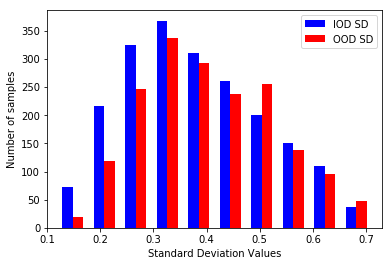

In [12]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[0], sd_test_OOD_df[0]], axis=0)
new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[0]), np.ones_like(sd_test_OOD_df[0])], axis=0)
histogram_df = pd.DataFrame(new_scores, new_labels)
print(new_scores.max())
print(new_scores.min())
#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[0])
b_heights, b_bins = np.histogram(sd_test_OOD_df[0], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()
ax.set_xlabel("Standard Deviation Values")
ax.set_ylabel("Number of samples")


0.556185177394322


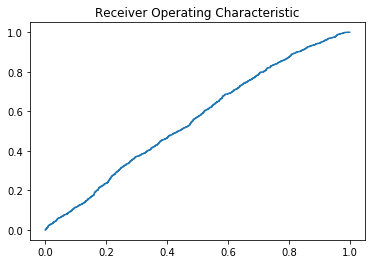

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.show()


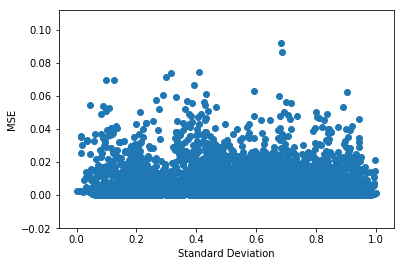

In [14]:
from sklearn.metrics import mean_squared_error

mean_test, sd_test = ensemble_model.predict(x_test)
mean_test = q_scaler.inverse_transform(mean_test)
#sd_test_IOD = q_scaler.inverse_transform(sd_test_IOD)
q_unorm = q_scaler.inverse_transform(q_test)

mean_test_df = pd.DataFrame(mean_test)
sd_test_df = pd.DataFrame(sd_test)
q_df = pd.DataFrame(q_test)

MEAN = np.array(mean_test_df[0])
SD = np.array(sd_test_df[0])
Q = np.array(q_df[0])
Q = Q.reshape(-1, 1)


mean_scaler = MinMaxScaler()
MEAN = mean_scaler.fit_transform(MEAN.reshape(-1, 1))
sd_scaler = MinMaxScaler()
SD = sd_scaler.fit_transform(SD.reshape(-1, 1))

MSE = np.square(np.subtract(Q, MEAN))
plt.figure()

plt.scatter(SD, MSE)
plt.xlabel('Standard Deviation')
plt.ylabel('MSE')
#plt.savefig("./Art.pdf")
plt.show()